# Stellar Interpretation for Meteoritic data and PLotting (for Everyone) - SIMPLE 

In [1]:
import sys

import os
import re
import numpy as np
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.axes._axes import _log as matplotlib_axes_logger; matplotlib_axes_logger.setLevel('ERROR')
# this mess of packages loaded can be improved
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import LogLocator


import matplotlib.pyplot as plt
#import data_dirlib.patches as patch
import time as t
import more_itertools as mit

import h5py
import csv

import datetime
#from datetime import datetime
import ast

# check if the abundance file is there. If it is not available, we load the models and we need more packages.
# or I just remove it and I go ahead with the typical mode
# if check_file is true, there is no need to load all the models again

!rm selected_abundances_data.txt
check_data_file = os.path.isfile('selected_abundances_data.txt')

#if check_data_file == False:
#    sys.path.append('/home/marco/work/NuGridPy')
#    from nugridpy import utils as u
#    from nugridpy import nugridse as mp
from nugridpy import utils as u
from nugridpy import nugridse as mp

# import function repository
%load_ext autoreload
%autoreload 2
from repo_functions import *

#%matplotlib nbagg
%pylab ipympl


# data stored
#data_dir="/data/nugrid/data/chetec-infra_models/"
data_dir="/data/nugrid_data/chetec-infra_models/"


Populating the interactive namespace from numpy and matplotlib


In [2]:
# getting the solar for SIMPLE
# this is here just for give_ratios. Once we will use only give_ratios_gm, this line will not be needed
#s_abu, s_iso_new = load_solar()

# load isotopic masses from isopy file (csv), based on Wang et al. 2017
with open('isotope_mass_W17.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, skipinitialspace=True)
    next(reader); next(reader)
    dum = []
    for row in reader:
        dum.append(row)
iso_dum = dum[0]; iso_masses = np.array([float(i) for i in dum[1]])

# here below some simple way to build the isotope name with the same structure of the models.
name_iso_masses = [re.sub(r'[0-9]+', '', i)+'-'+re.findall(r'\d+', i)[0] for i in iso_dum]

In [3]:
# from development made by Georgy... this is no good for now... here would work only for Fe and Ni
# why do I need this isotope_standard without using solar? Is this attached to a given experiment?
# If this is the case, then this should go in the input deck. 
# load isotope standard data

f = open('isotope_standards.txt', 'r')
standard_data = f.readlines()[1:]
f.close()

std_iso_temp = []
std_ratio = []

for i in standard_data:
    std_iso_temp.append(i[0:6].strip())
    std_ratio.append(float(i[9:]))
    
std_iso_temp = np.array(std_iso_temp)
std_ratio = np.array(std_ratio)

# converted here below to the same SIMPLE shape
std_iso = [i[:2].strip()+'-'+i[2:].strip() for i in std_iso_temp]
print(std_iso)
print(std_ratio)

['Fe-54', 'Fe-56', 'Fe-57', 'Fe-58', 'Ni-58', 'Ni-60', 'Ni-61', 'Ni-62', 'Ni-64']
[0.062669  1.        0.023261  0.0031132 2.596061  1.        0.043469
 0.1386    0.035295 ]


In [4]:
#read in the txt file for the required data
# MP: I think here should also go iso_list and e_label. Any reason why this is not the case?

with open('models.txt', 'r') as f:
    file = f.readlines()

reqmass = int(file[0].strip()) #required solar mass
rmodels = file[1].lower().split(',') ; rmodels = [i.strip() for i in rmodels] #required models
abu_elements=list(file[2].split(',')) ; abu_elements = [i.strip() for i in abu_elements]
abu_name=str(file[3].strip())

# delta, mu, etc for the isotopes you want for element 1
iso_up_plot=list(file[5].split(',')) ; iso_up_plot = [i.strip() for i in iso_up_plot] #stable isotopes
ratio1_elements=list(file[6].strip().split(',')); ratio1_elements = [i.strip() for i in ratio1_elements] #required isotopes
iso_down_plot = [file[7].strip()] * len(iso_up_plot)
iso_norm_mu_and_eps = [file[8].strip()] * len(iso_up_plot) # this is the isotope used for the double normalization
iso_norm_slope = file[9].strip() # isotope used for the normalization done on the epsilon or mu to get the slope
ratio1_name=str(file[10].strip())

for ln, line in enumerate(file):
    if 'iso_deck_start' in line:
        start_i = ln+1
    elif 'iso_deck_end' in line:
        end_i = ln
        
iso_list = []
e_label = []
isotopes = file[start_i:end_i]
for isotope in isotopes:
    parts = isotope.split('/')
    dum = parts[0].split(','); dum = [i.strip() for i in dum]; iso_list.append(dum)
    e_label.append(parts[1].strip())



In [5]:
# loading all models here, and write the required data in the file "selected_abundances_data.txt"

load_stellar_data(data_dir,check_data_file,reqmass,iso_list,e_label)


Searching files, please wait.......
Writing preprocessor files
M15.0Z2.0e-02.Ma.0020601.out.h5
 reading ['temperature']...100%

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/R18/h5Preproc.txt'



 reading ['mass']...100%Searching files, please wait.......
Writing preprocessor files
M20.0Z2.0e-02.Ma.0021101.out.h5
 reading ['temperature']...100%

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/R18/h5Preproc.txt'



 reading ['mass']...100%Searching files, please wait.......
Writing preprocessor files
M25.0Z2.0e-02.Ma.0023601.out.h5
 reading ['temperature']...100%

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/R18/h5Preproc.txt'



 reading ['mass']...100%Searching files, please wait.......
Writing preprocessor files
M3.00Z.0300.0096101.surf.h5
Searching files, please wait.......


Exception in thread Thread-9:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/agb_surf_m3z2m3/h5Preproc.txt'



Writing preprocessor files
M15.0Z2.0e-02.standard.0129401.restart.h5
M15.0Z2.0e-02.standard.0129501.restart.h5
M15.0Z2.0e-02.standard.0129301.restart.h5
 reading ['mass']...100%Searching files, please wait.......


Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/P16/h5Preproc.txt'



Writing preprocessor files
M20.0Z2.0e-02.standard.0132601.restart.h5
M20.0Z2.0e-02.standard.0132701.restart.h5
M20.0Z2.0e-02.standard.0132501.restart.h5
 reading ['mass']...100%Searching files, please wait.......


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/P16/h5Preproc.txt'



Writing preprocessor files
M25.0Z2.0e-02.standard.0097101.restart.h5
M25.0Z2.0e-02.standard.0096801.restart.h5
M25.0Z2.0e-02.standard.0096901.restart.h5
M25.0Z2.0e-02.standard.0097001.restart.h5
 reading ['mass']...100%/data/nugrid/data/chetec-infra_models/LAW22/M15s_run15f1_216M1.3bgl_mp.txt


Exception in thread Thread-19:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 517, in write
    f=open(filename,'w')
OSError: [Errno 30] Read-only file system: '/data/nugrid/data/chetec-infra_models/P16/h5Preproc.txt'



# particles =  949
/data/nugrid/data/chetec-infra_models/LAW22/M20s_run20f1_300M1.56jl_mp.txt
# particles =  1298
/data/nugrid/data/chetec-infra_models/LAW22/M25s_run25f1_280M1.83rrl_mp.txt
# particles =  1385
done with Lawson - 41.88 s
/data/nugrid/data/chetec-infra_models/R02/s15a28c.expl_yield
x transpose and done - 0.94 s
/data/nugrid/data/chetec-infra_models/R02/s20a28n.expl_yield
x transpose and done - 1.64 s
/data/nugrid/data/chetec-infra_models/R02/s25a28d.expl_yield
x transpose and done - 2.51 s
/data/nugrid/data/chetec-infra_models/LC18/015a000.dif_iso_nod
x transpose and done - 0.13 s
/data/nugrid/data/chetec-infra_models/LC18/020a000.dif_iso_nod
x transpose and done - 0.16 s
/data/nugrid/data/chetec-infra_models/LC18/025a000.dif_iso_nod
x transpose and done - 0.18 s
9
 reading ['iso_massf']...100%Sie18, missing isotope set to zero:  se64
Sie18, missing isotope set to zero:  se66
Sie18, missing isotope set to zero:  br66
Sie18, missing isotope set to zero:  mn66
Sie18, missi

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


All models loaded
Closing plot_tools
Closing plot_tools
Closing plot_tools
Closing plot_tools
Closing plot_tools
Closing plot_tools
Closing plot_tools


()

In [6]:
# and read from the file generated by the load function

data_pot = open('selected_abundances_data.txt','r')

data_pot.readline()
data  = data_pot.readlines()

data_pot.close()

# .... and rebuild the data back
# list of species to check and labels
iso_list = ast.literal_eval(data[0])
e_label  = ast.literal_eval(data[1])
# rau02
rau02_mass = np.array(ast.literal_eval(data[2])); rau02_abund = np.array(ast.literal_eval(data[3]))
# rit18
mass = np.array(ast.literal_eval(data[4])); r18_abund = np.array(ast.literal_eval(data[5]))
t9_cyc = np.array(ast.literal_eval(data[6]))
# pgn16
p16_mass = np.array(ast.literal_eval(data[7])); p16_abund = np.array(ast.literal_eval(data[8]))
p16_t9_cyc = np.array(ast.literal_eval(data[9]))
# law22
la22_mass = np.array(ast.literal_eval(data[10])); la22_abund = np.array(ast.literal_eval(data[11]))
# sie18
mass_sie = np.array(ast.literal_eval(data[12])); sie_abund = np.array(ast.literal_eval(data[13]))
# LC18
lc18_mass = np.array(ast.literal_eval(data[14])); lc18_abund = np.array(ast.literal_eval(data[15]))
# Bat20
agb_abund = np.array(ast.literal_eval(data[16]))


In [7]:
# delta, mu, etc for the isotopes you want for element 1
# THIS PART IS PROVIDED BY GABOR FILE NOW.
#iso_up_plot         = ['Ni-58','Ni-60','Ni-60*','Ni-61*','Ni-62','Ni-64','Ni-64*']
#iso_down_plot       = ['Ni-58']*len(iso_up_plot)
## these isotopes below should be included in iso_up_plot. 
## Check if they could be other isotopes, e.g., from other elements?
##iso_norm_mu_and_eps = 'Ni-58' # this is the isotope used for the double normalization
#iso_norm_mu_and_eps = ['Ni-61*']*len(iso_up_plot) # this is the isotope used for the double normalization
#iso_norm_slope      = 'Ni-62' # isotope used for the normalization done on the epsilon or mu to get the slope

# what function to use to calculate ratios
func_ratio_dum = give_ratios_gm #give_ratios # give_ratios_gm
# dilution : to be checked, does not work well
# linear : seems to be close to give_ratios
# better_linear : same result as give_ratios
# std_linear : some differences, but close enough (?)
method_dum = 'dilution' #'dilution' #'std_linear' # 'linear' # 'better_linear'
iteration_dum = 'precision'  # 'largest_offset' 'precision'

# getting the abundance ratio and everything for the models   
data_dump = \
func_ratio_dum(r18_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93.ppn'\
               , approximation_method = method_dum, iteration_method = iteration_dum)
rit_deltapmil = data_dump[0]; rit_slope = data_dump[1] ; rit_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(p16_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
p16_deltapmil = data_dump[0]; p16_slope = data_dump[1] ; p16_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(la22_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
law_deltapmil = data_dump[0]; law_slope = data_dump[1] ; law_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(sie_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot,iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab1.3E-02Lo03_Lo03_merged.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
sie_deltapmil = data_dump[0]; sie_slope = data_dump[1] ; sie_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(rau02_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'rau_solar_ref.ppn'\
              #, solar_ref_for_ratios = 'iniab1.9E-02AG89_AG89.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
rau_deltapmil = data_dump[0]; rau_slope = data_dump[1] ; rau_mind_slope = data_dump[2]

data_dump = \
func_ratio_dum(lc18_abund, e_label,iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab1.3E-02As09_As09_merged.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
lc18_deltapmil = data_dump[0]; lc18_slope = data_dump[1] ; lc18_mind_slope = data_dump[2]

# test AGB -Battino+
# getting the abundance ratio and everything for the models   
data_dump = \
func_ratio_dum(agb_abund, e_label, iso_masses, name_iso_masses, iso_up_plot, iso_down_plot, iso_norm_mu_and_eps, iso_norm_slope\
              , solar_ref_for_ratios = 'iniab2.0E-02GN93_Lo03.ppn'\
              , approximation_method = method_dum, iteration_method = iteration_dum)
bat_deltapmil = data_dump[0]; bat_slope = data_dump[1] ; bat_mind_slope = data_dump[2]




step 1 dilution_factor = 1
step 2 dilution_factor = 0.1
step 3 dilution_factor = 0.010000000000000002
step 4 dilution_factor = 0.0010000000000000002
step 5 dilution_factor = 0.00010000000000000003
step 6 dilution_factor = 1.0000000000000004e-05
step 7 dilution_factor = 1.0000000000000004e-06
step 8 dilution_factor = 1.0000000000000005e-07
step 9 dilution_factor = 1.0000000000000005e-08
step 10 dilution_factor = 1.0000000000000005e-09
step 11 dilution_factor = 1.0000000000000006e-10
step 12 dilution_factor = 1.0000000000000006e-11
step 13 dilution_factor = 1.0000000000000006e-12
dilution_factor too small, max slope_diff = 1.97568811307998 
took 13 iterations, final dilution_factor 1.0000000000000008e-14
step 1 dilution_factor = 1
step 2 dilution_factor = 0.1
step 3 dilution_factor = 0.010000000000000002
step 4 dilution_factor = 0.0010000000000000002
step 5 dilution_factor = 0.00010000000000000003
step 6 dilution_factor = 1.0000000000000004e-05
step 7 dilution_factor = 1.0000000000000004

/user/scratch14_wendi3/marco/chetec-infra_WP9/repo_functions.py:398: RuntimeWarning: divide by zero encountered in true_divide
  slope = np.array(rho_mind/rho_mind_slope + 1e-200)
/user/scratch14_wendi3/marco/chetec-infra_WP9/repo_functions.py:398: RuntimeWarning: invalid value encountered in true_divide
  slope = np.array(rho_mind/rho_mind_slope + 1e-200)


In [8]:
#print('precision')
#print(len(sie_abund),len(sie_abund[0]))
#print(len(r18_abund),len(r18_abund[0]))
#print(len(p16_abund),len(p16_abund[0]))
#print(len(la22_abund),len(la22_abund[0]))
#print(len(rau02_abund),len(rau02_abund[0]))
#print(len(lc18_abund),len(lc18_abund[0]))
###
#print(len(agb_abund),agb_abund)
#print(bat_slope)
#print(lc18_slope[1])


# Compile data

Here all the loaded data is put into a single dictionary. This should be easy to traverse as its the same keys to get everything.

The structure is:
``all_models[model_name][model_mass][data_type]``

the data types are:
- ``masscoord`` - An array with the mass coordinates
- ``abu`` - A dictionary containing the abundances. Mapped to e_label
- ``slope`` - A dictionary containing the slopes. Mapped to iso_up_plot/iso_norm_slope

In [9]:
# from the part here on, this new dictionary could be used for the figures. Once implemented, it should generate the same figures as before

slope_isotopes = tuple(f"{n}/{iso_down_plot[0]}" for n in iso_up_plot)
abu_isotopes = e_label

r18_ind_tmp = np.where(t9_cyc > 1.1e-9)[0][0]
p16_ind_tmp = np.where(p16_t9_cyc < 1.1e-10)[0][0]

label_models = ['Ri18', 'Pi16', 'La22', 'Si18', 'LC18', 'Ra02']
model_inputs=[(label_models[0], mass[r18_ind_tmp:], tuple(a[r18_ind_tmp:] for a in r18_abund), tuple(a[r18_ind_tmp:] for a in rit_slope), \
               #tuple(a[r18_ind_tmp:] for a in rit_mind_slope), 
               tuple(a[r18_ind_tmp:] for a in rit_deltapmil)),
              (label_models[1], p16_mass[p16_ind_tmp:], tuple(a[p16_ind_tmp:] for a in p16_abund), tuple(a[p16_ind_tmp:] for a in p16_slope), \
              #tuple(a[p16_ind_tmp:] for a in p16_mind_slope),
               tuple(a[p16_ind_tmp:] for a in p16_deltapmil)),
              (label_models[2], la22_mass, la22_abund, law_slope, \
               #law_mind_slope, 
               law_deltapmil),
              (label_models[3],  mass_sie[:], sie_abund, sie_slope, \
               #sie_mind_slope, 
               sie_deltapmil),
              (label_models[4], lc18_mass, lc18_abund, lc18_slope, \
               #lc18_mind_slope, 
               lc18_deltapmil),
              (label_models[5], rau02_mass, rau02_abund, rau_slope, \
               #rau_mind_slope, 
               rau_deltapmil)]


all_models = {}
for name, masscoord, abu, slope, ratio_minus_1 in model_inputs:
    all_models[name] = {reqmass: {}}
    all_models[name][reqmass]['masscoord'] = masscoord
    all_models[name][reqmass]['abu'] = {iso: abu[i] for i, iso in enumerate(abu_isotopes)}
    all_models[name][reqmass]['slope'] = {iso: slope[i] for i, iso in enumerate(slope_isotopes)}
    #all_models[name][reqmass]['slope_sign'] = {iso: slope_sign for i, iso in enumerate(slope_isotopes)}
    all_models[name][reqmass]['isoratio_minus_1'] = {iso: ratio_minus_1[i] for i, iso in enumerate(slope_isotopes)}
    # We could also add the corresponding solar value here so that its easy to get

In [10]:
#slope_isotopes

# Start the data-mining!

Here it is possible to immediately start the data-mining. Some examples of plots are following

List of plots templates:
...


In [11]:
# before the plots, some common definitions to share across plots

# colors and marker symbols
#col = np.r_[[[0.0, 0.0, 0.0, 1.0]], cm.rainbow(np.linspace(0, 1,20))]
col=["black", "blue", "brown","red","darkolivegreen","deepskyblue","darkorange",\
     "darkorchid","darkkhaki","mediumvioletred","limegreen"]*6
lin = 'o'
llin='+'
lllin='s'

# xlabels and ylabels in the plots
xlabel1 = 'Mass coordinate M$_{\odot}$'
xlabel2 = 'Time coordinate'

ylabel1 = 'X'; ylabel2 = 'Solar ratio - 1.'
ylabel3 = '$\epsilon$('+iso_norm_mu_and_eps[0]+')'

normlabel=iso_norm_slope.split("-")
downlabel=iso_down_plot[0].split("-")
normmulabel=iso_norm_mu_and_eps[0].split("-")

if '*' in normlabel[1]:
    normlabel[1] = normlabel[1].replace('*', '')
if '*' in downlabel[1]:
    downlabel[1] = downlabel[1].replace('*', '')
if '*' in normmulabel[1]:
    normmulabel[1] = normmulabel[1].replace('*', '')
    
ylabel4 = f'slope relative to $\\epsilon^{{{normlabel[1]}}}{{\\rm {normlabel[0]}}}_{{{downlabel[1]}/{normmulabel[1]}}}$'




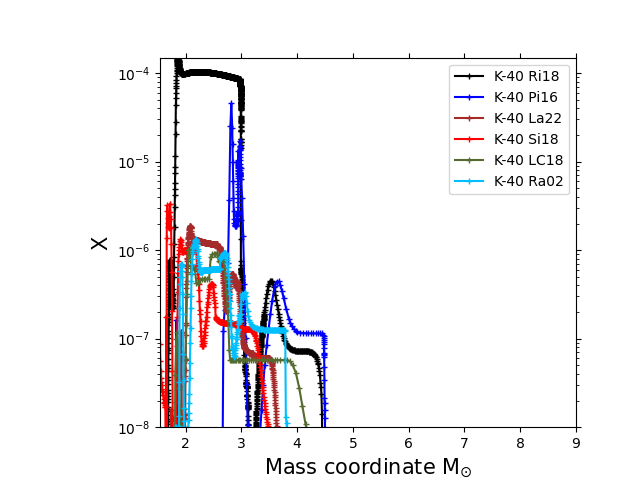

In [12]:
# abundance plot for selected isotopes; and different models
ifig=24
plt.figure(ifig).clear(); plt.figure(ifig)

iso_selected = 'K-40'
ind_ = abu_isotopes.index(iso_selected)

for i in range(len(all_models)):
    plt.semilogy(all_models[label_models[i]][reqmass]['masscoord'],all_models[label_models[i]][reqmass]['abu'][iso_selected],color=col[i],marker=llin,markersize=4,ls='-',\
                 label=iso_selected + ' '+label_models[i])

plt.legend(loc='upper right')
masscut = min(min(all_models[label_models[i]][reqmass]['masscoord']) for i in range(len(all_models)))
plt.xlim(masscut,9); plt.ylim(1e-8,1.5e-4)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel1,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

plt.savefig('test'+str(reqmass)+'_'+iso_selected+'.pdf')
plt.show()


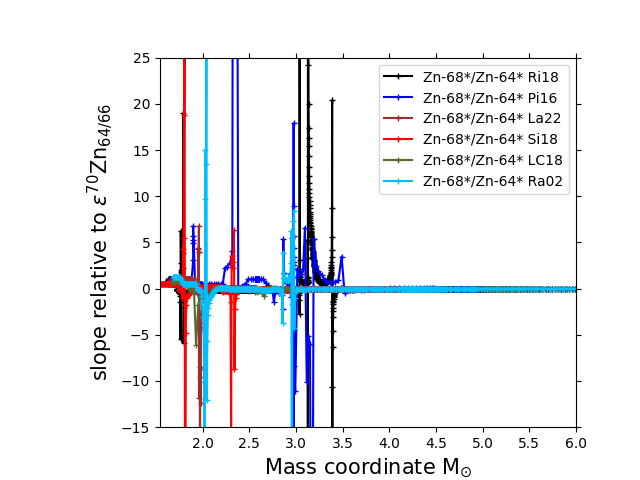

In [13]:
# plot slopes for selected isotopes, for different models
ifig=25
plt.figure(ifig).clear(); plt.figure(ifig)

iso_selected = 'Zn-68*/Zn-64*'

for i in range(len(all_models)):
    plt.plot(all_models[label_models[i]][reqmass]['masscoord'],all_models[label_models[i]][reqmass]['slope'][iso_selected],color=col[i],marker=llin,markersize=4,ls='-',\
                 label=iso_selected + ' '+label_models[i])

plt.legend(loc='upper right')
masscut = min(min(all_models[label_models[i]][reqmass]['masscoord']) for i in range(len(all_models)))
plt.xlim(masscut,6) ; plt.ylim(-15,25)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel4,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

#plt.savefig('test'+iso_selected+'.pdf')
plt.show()


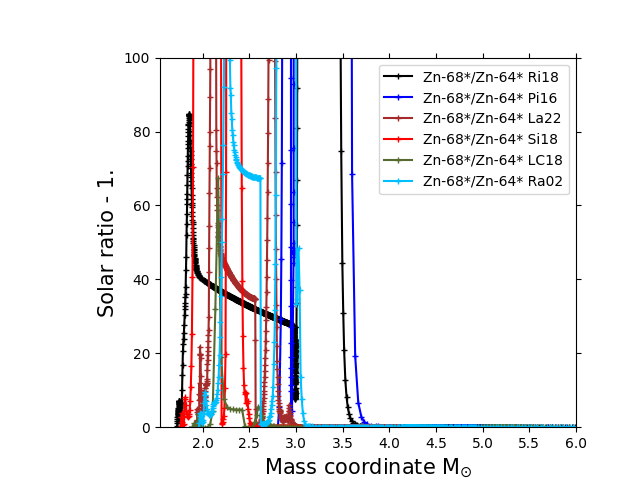

In [14]:
# plot solar ratio - 1 for selected isotopes, for different models
ifig=26
plt.figure(ifig).clear(); plt.figure(ifig)

iso_selected = 'Zn-68*/Zn-64*'

for i in range(len(all_models)):
    plt.plot(all_models[label_models[i]][reqmass]['masscoord'],all_models[label_models[i]][reqmass]['isoratio_minus_1'][iso_selected],\
             color=col[i],marker=llin,markersize=4,ls='-',\
                 label=iso_selected + ' '+label_models[i])

plt.legend(loc='upper right')
masscut = min(min(all_models[label_models[i]][reqmass]['masscoord']) for i in range(len(all_models)))
plt.xlim(masscut,6) ; plt.ylim(0,100)
plt.xlabel(xlabel1,fontsize=15); plt.ylabel(ylabel2,fontsize=15)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)

plt.gcf().subplots_adjust(left=0.25)    

#plt.savefig('test'+iso_selected+'.pdf')
plt.show()


m_cut: 1.6105417670092237
massmax: 12.15340998801299
Lower boundary of the H shell: 4.79860944687067
Lower boundary of the He/N shell: 4.446022895845686
Lower boundary of the He/C shell: 3.103586549163745
Lower boundary of the O/C shell: 2.9877129568426066
Lower boundary of the O/Ne shell: 2.9877129568426066
Lower boundary of the O/Si layer: 1.7118590207943605
Lower boundary of the Si layer: 1.6569642910550864
Lower boundary of the Ni layer: 1.6108472016903488


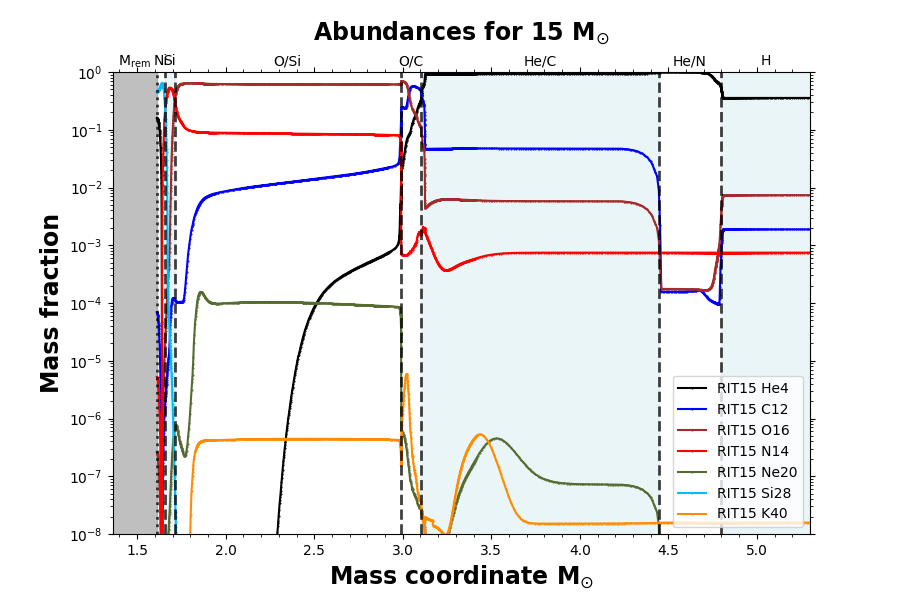

()

In [15]:
# abundance plot with mass vs mass coordinate with structure grid

# list of isotopes used for this plot (provided in models.txt)
iso_selected = abu_elements    

title_abundance_plot ="Abundances for "+str(reqmass)+" M$_{\odot}$"
abundanceplot(e_label, rmodels, iso_selected, reqmass, all_models, title_abundance_plot, col, lin, \
               x1=1.5, x2=5.5, y1=1e-8, y2=1, legendpos='inside', abu_name="onion_test.png",onion=True)

m_cut: 1.6105417670092237
massmax: 12.15340998801299
Lower boundary of the H shell: 4.79860944687067
Lower boundary of the He/N shell: 4.446022895845686
Lower boundary of the He/C shell: 3.103586549163745
Lower boundary of the O/C shell: 2.9877129568426066
Lower boundary of the O/Ne shell: 2.9877129568426066
Lower boundary of the O/Si layer: 1.7118590207943605
Lower boundary of the Si layer: 1.6569642910550864
Lower boundary of the Ni layer: 1.6108472016903488


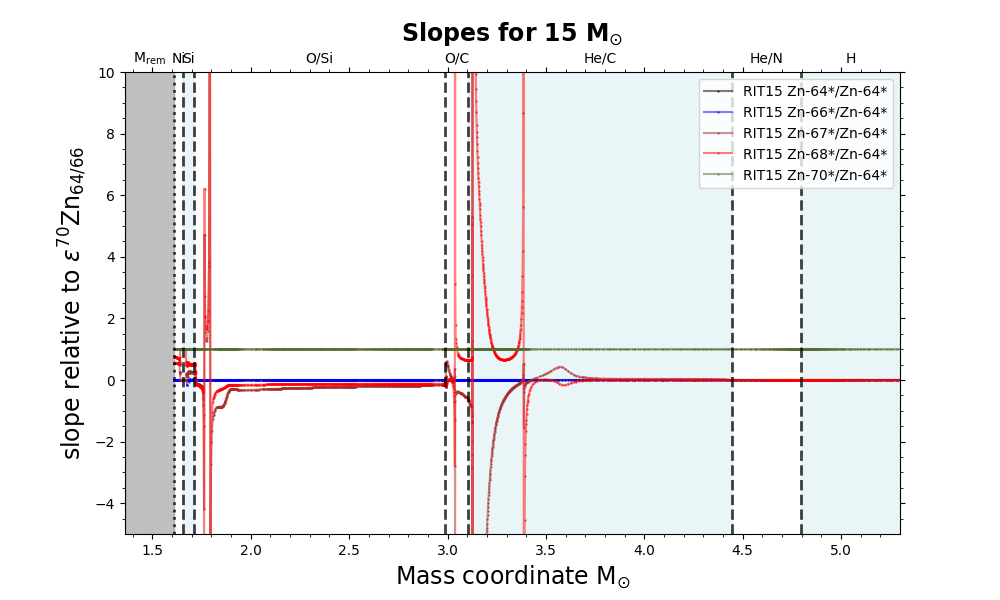

In [16]:
# plot slopes with onion structure on the background (e.g., Meyer+ 1995)
#
iso_selected = slope_isotopes


plot_ylabel = ylabel4
title_plot = "Slopes for "+str(reqmass)+" M$_{\odot}$"

ratioplot(rmodels, iso_selected, reqmass, all_models, plot_ylabel, title_plot, col, lin,\
          x1=1.5, x2=5.5, y1=-5, y2=10, ratio_name="slopes_and_structure_test.png",onion=True)


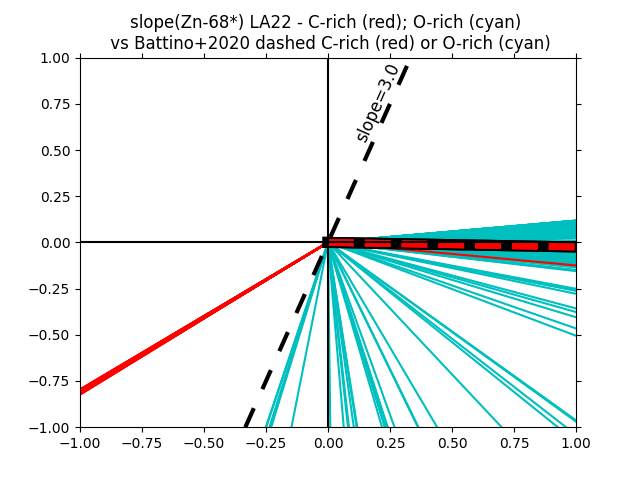

In [17]:
# ratio plot; slopes
ifig=76
plt.figure(ifig).clear(); plt.figure(ifig)

#iso_plot = 'Ni-64*'; iso_ref = 'Ni-61'
iso_plot = 'Zn-68*'; iso_ref = 'Zn-66'
ind_ = iso_up_plot.index(iso_plot)
indu_ = e_label.index(iso_plot); indd_ = e_label.index(iso_ref) 
indn_ = e_label.index(iso_norm_mu_and_eps[0]) ; inds_ = e_label.index(iso_norm_slope) 

ind_c12 = e_label.index("C-12"); ind_o16 = e_label.index("O-16")

# check kind of production factor of lim_relevance, otherwise do not show slope
lim_relevance = 5e0

#what_slope = rau_slope; what_abu = rau02_abund; surf_ind = -1
#what_slope = sie_slope; what_abu = sie_abund; surf_ind = -1 
#what_slope = rit_slope; what_abu = r18_abund; surf_ind = -1
what_slope = law_slope; what_abu = la22_abund; what_mind = law_mind_slope; surf_ind = -1  
#what_slope = lc18_slope; what_abu = lc18_abund; surf_ind = -1  
#what_slope = p16_slope; what_abu = p16_abund; surf_ind = -1

# get the sign for y and x. The sign for y is given by what_mind, the sign for x is given by the sign(what_mind)*sign(what_slope)
sign_x = np.sign(what_mind); sign_y = sign_x * np.sign(what_slope[ind_])


[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], ls='-', c='c') for i in range(len(what_slope[ind_])) if\
    what_abu[ind_][i] > lim_relevance * what_abu[ind_][surf_ind] or \
    what_abu[indd_][i] > lim_relevance *  what_abu[indd_][surf_ind] or \
    what_abu[indn_][i] > lim_relevance *  what_abu[indn_][surf_ind] or \
    what_abu[inds_][i] > lim_relevance *  what_abu[inds_][surf_ind] \
    if what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], ls='-', c='r') for i in range(len(what_slope[ind_])) if\
    what_abu[ind_][i] > lim_relevance *  what_abu[ind_][surf_ind] or \
    what_abu[indd_][i] > lim_relevance *  what_abu[indd_][surf_ind] or \
    what_abu[indn_][i] > lim_relevance *  what_abu[indn_][surf_ind] or \
    what_abu[inds_][i] > lim_relevance *  what_abu[inds_][surf_ind] \
    if what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]

# add comparison - AGB - crazy here since I have only one final snapshot
# note that here below I cannot use surface abundances as indicative anymore....
# well, this is not safe to do either for CCSNe with WR progenitors, Novae, etc. So, all of this will need to
# changed, and use solar as reference or solar scaled.
#what_slope = np.transpose(np.concatenate(([bat_slope], [bat_slope]), axis=0))
#what_abu = np.transpose(np.concatenate(([agb_abund], [agb_abund]), axis=0)) 
what_slope = bat_slope
what_abu = agb_abund
what_mind = bat_mind_slope
surf_ind = -1        

# get the sign for y and x. The sign for y is given by what_mind, the sign for x is given by the sign(what_mind)*sign(what_slope)
sign_x = np.sign(what_mind); sign_y = sign_x * np.sign(what_slope[ind_])

[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], c='k',ls='-',lw=8)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], c='k',ls='-',lw=8)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]
[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], c='c',ls='--',lw=5)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]<1]
[plt.plot([0.,1.*sign_x[i]],[0.,1.*np.abs(what_slope[ind_][i])*sign_y[i]], c='r',ls='--',lw=5)  for i in range(len(what_slope[ind_])) if\
    what_abu[ind_c12][i]/what_abu[ind_o16][i]>1]

plt.axhline(y=0,color='k'); plt.axvline(x=0,color='k')

# slope from obs?
sl = 3.0
plt.axline((0, 0.0), slope=sl, color="black", linestyle=(0, (5, 5)), lw=3)
plt.text(0.1, 0.55, "slope="+str(sl), rotation=66, fontsize=12)

plt.title('slope('+iso_plot+\
          ') LA22 - C-rich (red); O-rich (cyan) \n vs Battino+2020 dashed C-rich (red) or O-rich (cyan)')
#plt.title('slope('+iso_plot+\
#          ') SI18 - C-rich (red); O-rich (cyan) \n vs Battino+2020 dashed C-rich (red) or O-rich (cyan)')

plt.xlim(-1,1); plt.ylim(-1,1)
plt.tick_params(left=True,right=True,top=True,labelleft=True,which='both') #,labelright=True)


plt.savefig('la22_vs_bat20'+iso_plot+'slope.pdf')

plt.show()


# Multi-level rose diagram

under development, it works just fine with python3.9.13 but it does not work with python3.6.9 (layout issue -- easy to solve --, handling of colormaps -- tricky)

In [18]:
def as1darray(*a, dtype=np.float64):
    size = None
    
    out = [np.asarray(x, dtype=dtype) if x is not None else x for x in a]
    
    for o in out:
        if o is None:
            continue
        if o.ndim == 1 and o.size != 1:
            if size is None:
                size = o.size
            elif o.size != size:
                raise ValueError('Size of arrays do not match')
        elif o.ndim > 1:
            raise ValueError('array cannot have more than 1 dimension')
    
    out = tuple(o if (o is None or (o.ndim == 1 and o.size != 1)) else np.full(size or 1, o) for o in out)
    if len(out) == 1:
        return out[0]
    else:
        return out

# TODO xlabel, ylabel, weight_label
# TODO figure out how to plot legend for the histograms. Seperate subfigure?
# This how to deal with this in a subplot?
# constrained layout messes with putting figure labels on subfigure
class MLR:
    """
    Multi-level rose diagram where you can plot data/histograms of directional data on concentric circles.

    Parameters
    ----------
    xylim : (float, float)
        A tuple containing a value that represents the positive, and negative extent, of the x and y axes.    
    xylabels :(str, str)
        A tuple containing the labels for the x and y axes. 
    segment : {'N', 'S', 'E', 'W', 'All'}
        Can be used to only show a segment of the full circle. Default is ``'All'``.
    xylabel_pos : {'N', 'S', 'E', 'W', None}
        The position of the x and y labels. Default position depends on the label.
    cmap : str
        The colour map to the be used. If no color map is given then ``'turbo'`` will be used but no legend will be shown.
        See [matplotlib](https://matplotlib.org/stable/users/explain/colors/colormaps.html) docs for a list of avaliable 
        colour maps.
    cmap_vmin : float
        The lower limit of the color map range. Default to 0 or, if ``cmap_log`` is ``True``, 1E-10.
    cmap_vmax : float
        The upper limit of the colour map range. If no value is given then the default is 1 and the data will be
        normalised against the largest value when ``histxy`` or ``histm`` is called. If a value is given then the data will
        not be normalised (even if that value is 1).
    cmap_log : bool
        If ``True`` a the colour map will use a log scale. Defaults to ``False``.
    cmap_label : str
        The label for the colour map legend.
    """

    # Made by Mattias Ek & Chiara Incollingo
    def __init__(self, xylim = (1.0, 1.0), xylabels = (None, None), segment='All', xylabel_pos = None,
                 cmap = None, cmap_vmin=None, cmap_vmax = None, cmap_log = False, cmap_label = None):
        self.ylim = np.abs(xylim[0])
        self.xlim = np.abs(xylim[1])
        self.xscale = 1/np.abs(self.xlim)
        self.yscale = 1/np.abs(self.ylim)
        self.mscale = self.yscale/self.xscale
        
        #Create figure
        #self.figure, self.axes = plt.subplots(subplot_kw={'projection': 'polar'}, layout="constrained")
        self.figure, self.axes = plt.subplots(subplot_kw={'projection': 'polar'})
        self.axes.set_theta_zero_location('N')
        self.axes.set_theta_direction(-1)
        #self.axes.set_thetagrids((np.pi*0, np.pi*0.5, np.pi*1, np.pi*1.5), (self.xscale, self.yscale, self.xscale*-1, self.yscale*-1))
        self.axes.set_thetagrids((0, 90, 180, 270), (self.yscale, self.xscale, self.yscale*-1, self.xscale*-1))
        
        if cmap_vmax is None:
            self.cmap_common_vmax = False
            self.cmap_vmax = 1
        else:
            self.cmap_common_vmax = True
            self.cmap_vmax = cmap_vmax
            
        if cmap_log:
            self.cmap_vmin = 1E-10 if cmap_vmin is None else cmap_vmin
            self.cmap_normalizer = mpl.colors.LogNorm(self.cmap_vmin, self.cmap_vmax)
            
        else:
            self.cmap_vmin = 0 if cmap_vmin is None else cmap_vmin
            self.cmap_normalizer = mpl.colors.Normalize(self.cmap_vmin, self.cmap_vmax)    
        
        if cmap:
            #self.cmap = mpl.colormaps['turbo' if cmap is True else cmap]
            self.cmap = plt.get_cmap('turbo')
            self.figure.colorbar(mpl.cm.ScalarMappable(self.cmap_normalizer, self.cmap), ax=self.axes)
            
        else:
            self.cmap = mpl.colormaps['turbo']
        
        if segment.upper() == 'N':
            self.axes.set_thetalim(-np.pi*0.5, np.pi*0.5)
            self.axes.set_thetagrids((-90, 0, 90), (-self.xscale, self.yscale, self.xscale))
        elif segment.upper() == 'S':
            self.axes.set_thetalim((np.pi*0.5, np.pi*1.5))
            self.axes.set_thetagrids((90, 180, 270), (-self.xscale, -self.yscale, self.xscale))
        elif segment.upper() == 'E':
            self.axes.set_thetalim(0, np.pi)
            self.axes.set_thetagrids((0, 90, 180), (self.yscale, self.xscale, -self.yscale))
        elif segment.upper() == 'W':
            self.axes.set_thetalim(np.pi, np.pi*2)
            self.axes.set_thetagrids((180, 270, 360), (-self.yscale, -self.xscale, self.yscale))
        else:
            self.axes.set_thetagrids((0, 90, 180, 270), (self.yscale, self.xscale, self.yscale*-1, self.xscale*-1))
        
        self.axes.set_yticklabels([])
        # TODO set theta labels to correspont do scale
        # Use N, NE etc to select only a segment of the plot
    
    def point2rad(self, x, y):
        """
        Convert the point ``x, y`` into an angle, in radians, within the space defined by the
        objects ``xlim`` and ``ylim`` limits.
        """
        x, y = as1darray(x, y)
        return np.array([self._point2rad_(x[i]*self.xscale, y[i]*self.yscale) for i in range(x.size)])
    
    @staticmethod
    def _point2rad_(x, y):
        """
        Convert ``x, y`` to a angle in radians. Only accepts scalar values. 
        """
        if x == 0:
            return np.pi/2
        if y == 0:
            return 0


        if x > 0:
            return np.pi * 0.5 - np.arctan(y/x)
        else:
            return np.pi * 1.5 - np.arctan(y/x)

    def pointxy(self, x, y, r = 1, **kwargs):
        """
        Add a data point to the figure at radius ``r`` of the slope defined by the point (``x``, ``y``).
        
        Any additional keyword arguments will be passed onto matplotlibs 
        [scatter](matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html) function.
        """
        x, y = as1darray(x, y)
        self.axes.scatter(self.point2rad(x,y), r, **kwargs)
    
    def pointxm(self, x, m, r = 1, merr= None, **kwargs):
        """
        Add a data point to the figure at radius ``r`` of the slope ``m`` at ``x``. 
        
        If the error of the slope, ``merr``, is given then a line will be drawn along ``r`` with the same
        colour as the data point.
        
        Any additional keyword arguments will be passed onto matplotlibs 
        [scatter](matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html) function.
        """
        x, m, merr = as1darray(x, m, merr)
        
        point_lines = self.axes.scatter(self.point2rad(x, m*x), r, **kwargs)
        
        if merr:
            rn = 100
            theta = np.linspace(self.point2rad(x, (m-merr)*x), self.point2rad(x, (m+merr)*x), rn)
            merr_lines = self.axes.plot(theta, np.full(rn, r), color = point_lines.get_facecolor(), zorder=0.99, marker="")
    
    # add x as optional and if given plot point
    def slope(self, m, merr=None, merr_line = '--', merr_alpha = 0.2, rmax = None, **kwargs):
        """
        Draw a line if slope ``m`` on the figure.
        
        The line will be drawn within the current radius limit of the figure unless ``rmax`` is given.
        
        If ``merr``is is given the uncertiainty of the slope will be drawn using the ``merr_line`` linestyle and
        the are between the lines shaded with an alpha value of ``merr_alpha``. You can disable either of these by
        setting the value to ``False``.
        
        Any additional keyword arguments will be passed onto matplotlibs 
        [plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html) function.
        """
        ax = self.axes
        rmax = rmax or ax.get_rmax()
        slope_kwargs = {'linestyle': '-', 'linewidth': 1}
        slope_kwargs.update(kwargs)

        slope_line = ax.plot(self.point2rad([1, -1], [m, m*-1]), [rmax, rmax], marker="", **slope_kwargs)[0]
        if merr is not None:

            if merr_line:
                slope_kwargs = {'linestyle': merr_line, 'linewidth': 1, 'color': slope_line.get_color()}

                ax.plot(self.point2rad([1, -1], [(m+merr), (m+merr)*-1]), [rmax, rmax], marker="", **slope_kwargs)
                ax.plot(self.point2rad([1, -1], [(m-merr), (m-merr)*-1]), [rmax, rmax], marker="", **slope_kwargs)

            if merr_alpha:
                rn = 100
                theta1 = np.linspace(self.point2rad(1, (m-merr)), self.point2rad(1, (m+merr)), rn)
                theta2 = np.linspace(self.point2rad(-1, (m+merr)*-1), self.point2rad(-1, (m-merr)*-1), rn)
                ax.fill(np.append(theta1, theta2), np.full(rn*2, rmax), alpha = merr_alpha, facecolor=slope_line.get_color())
    
    def histxy(self, x, y, r, weights=1, nbins=72, rwidth=0.9, rscale = 'rel', vmax = None, antipodal=False):
        """
        Create a circular histogram of the slope defined by the (``x``, ``y``) data point with ``weights``, starting at the radius ``r``. 
        
        The entire circle is divided into ``nbins`` segments of equal size. By default one segment every 5°. 
        
        The colour of each segment corresponds to the colour map range. If ``vmax`` is given then the bin weights are normalised to 
        that value. If it is not specified and ``cmap_vmax'' is not specified then
        the bin weights are normalised against the maximum bin weight.
        
        The colur of each segment is determiend by the bin weight relative to the colour map range.
            - If ``rscale`` is ``"rel"`` then width of the maximum bin weight is set to ``rwidth``.
            - if ``rscale`` is ``"abs"`` then the ``rwidth`` corresponds to the maximum value of the colour map range.
            - If ``rscale`` is ``False`` then the width of each bin is equal to ``rwidth`` (Independent of bin weight).
        
        If ``antipodal`` is ``True`` the weight of point (``x``, ``y``) will also be added to its antipode.
        """
        x, y, weights = as1darray(x, y, weights)
        
        theta = self.point2rad(x, y)
        if antipodal:
            theta = np.append(theta, self.point2rad(-1, (y/x)*-1))
            weights = np.append(weights, weights)
        
        bin_weights, bin_edges = np.histogram(theta, bins=nbins, range=(0, np.pi*2), weights=weights, density=False)
        
        if vmax is None:
            if self.cmap_common_vmax is False:
                vmax = np.max(bin_weights)
            else:
                vmax = self.cmap_vmax
        
        bin_weights = bin_weights / vmax
            
        if not rscale:
            bin_widths = np.full(bin_weights.size, rwidth)
        else:
            bin_widths = np.array([self.cmap_normalizer(bw, clip=True) for bw in bin_weights])
            if rscale == 'abs':
                bin_widths = bin_widths * rwidth
            elif rscale == 'rel':
                bin_widths = (bin_widths*1/np.max(bin_widths))*rwidth
                
        bin_colors = np.array([self.cmap(self.cmap_normalizer(bw)) for bw in bin_weights])

        for i in range(nbins):
            rn = 100
            #edges = np.append(e:=np.linspace(bin_edges[i], bin_edges[i+1], rn), np.flip(e))
            e = np.linspace(bin_edges[i], bin_edges[i+1], rn)
            edges = np.append(e, np.flip(e))
            rs = np.append(np.full(rn, r), r + np.full(rn, bin_widths[i]))
            #print(len(edges),len(rs),len(e))
            
            self.axes.fill(edges, rs, alpha = 1, facecolor=bin_colors[i])
    
    def histm(self, m, r, weights=1, bins=72, rwidth=0.9, rscale = 'rel', vmax=None):
        """
        Create a circular histogram of the slope defined by the ``m`` with ``weights``, starting at the radius ``r``.
        
        See ``histxy`` method for details of additional arguments.
        """
        m = as1darray(m)
        return self.histxy(np.full(m.size, 1), m , r, weights, bins, rwidth, rscale, vmax, antipodal=True)
    
    def set_rlim(self, rmin, rmax):
        """
        Set the radius limits of the figure.
        """
        self.axes.set_rlim((rmin,rmax))

In [19]:
# # Test case
# rng = np.random.default_rng()
# 
# x = rng.normal(1,1, 1000)
# y = rng.normal(1,1, 1000)
# weights = rng.uniform(1,100, 1000)
# 
# ax = MLR(cmap = 'turbo')
# ax.histxy(x, y, 1, 1)
# ax.histm(y/x, 2, 10)
# 
# ax.pointxm(1,1, merr=0.5, r=4)
# ax.pointxm(1, -1, merr=0.5, r=2.9, edgecolor='black')
# 
# ax.slope(1, merr=0.5)
# ax.slope(1.2, merr=0.1)
# ax.set_rlim(0,4.1)
# plt.tight_layout()

In [20]:
## Each point in the model has the same weight
#ax = MLR(cmap = 'turbo', cmap_log = True, cmap_vmin=0.001)
#
#for j, name in enumerate(all_models.keys()):
#    ax.histm(all_models[name][reqmass]['slope']['Ni-64*/Ni-62*'], j+1)

In [21]:
## The weight of each point is equal to the sum of the abundance of all Ni isotopes
#ax = MLR(cmap = 'turbo', cmap_log = True, cmap_vmin=0.001)
#weight_isotopes = [iso for iso in abu_isotopes if (iso.startswith('Ni') and iso.endswith('*'))]
#print(weight_isotopes)
#
#for j, name in enumerate(all_models.keys()):
#    weight = np.sum([all_models[name][reqmass]['abu'][iso] for iso in weight_isotopes], axis=0)
#    
#    ax.histm(all_models[name][reqmass]['slope']['Ni-64*/Ni-62*'], j+1, weights = weight, vmax = np.sum(weight))#

In [22]:
# when 2 elements are involved...
#ref_EL1_el2 = 'Ni-61'
#ref_el1_EL2 = 'Fe-56'

# correcting quantities in case slope or mu are compared against different elements
# this should work for whatever correct combination:
# rit* with r18_abund; law* with y and sie* with sie_abund
# ...
#rit_dsm_corr = func_el_corr(rit_dsm, r18_abund, ref_EL1_el2, ref_el1_EL2, mode=1)
#rit_dsm_corr = func_el_corr(rit_slope2, r18_abund, ref_EL1_el2, ref_el1_EL2, mode=2,\
#                            file_fractionation='sandbox_element_correction.txt',what_in_file='O-rich_Isaac')

In [23]:
# test solar vs standard-reference-material
# all of those are ratios, all relatives to Ni60, dimensionless
#srm5861 = 2.596061 / 0.043469 
#srm6061 = 1 / 0.043469
#srm6261 = 0.138600 / 0.043469
#srm6461 = 0.035295 / 0.043469

#s5861 = s_abu[s_iso_new.index('Ni-58')]/s_abu[s_iso_new.index('Ni-61')] * (61./58.)
#s6061 = s_abu[s_iso_new.index('Ni-60')]/s_abu[s_iso_new.index('Ni-61')] * (61./60.)
#s6261 = s_abu[s_iso_new.index('Ni-62')]/s_abu[s_iso_new.index('Ni-61')] * (61./62.)
#s6461 = s_abu[s_iso_new.index('Ni-64')]/s_abu[s_iso_new.index('Ni-61')] * (61./64.)

#print(s5861,srm5861,s5861/srm5861)
#print(s6061,srm6061,s6061/srm6061)
#print(s6261,srm6261,s6261/srm6261)
#print(s6461,srm6461,s6461/srm6461)

#corr_srm = np.array([s5861/srm5861, s6061/srm6061, s6061/srm6061 ,s6261/srm6261, s6461/srm6461 ])